In [1]:
# Author: Rebekah Esmaili

# Pre-requisites:
# To run this script, you will need to follow the steps in the https://github.com/NUCAPS/SHARPpy
# This will generate the SHARPpy-formatted text files from the NUCAPS EDR, which is in netCDF4.
# After running the script, you will need to locate the output files from /home/{user}/.sharppy/datasources.
# In the above directory, there is a csv file named "<j01/npp>_case_study.csv" and the *.txt files in the 
# directory <j01/npp>... update the path to these files below:

csv_fname = "j01/j01_case_study.csv"
txt_ddir = "j01/*.txt"


# Also you need to have a bunch of libraries....

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import glob
from io import StringIO
import sys

In [2]:
# This function reads the text files, we'll call it later.
def parseSPC(spc_file):
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0][0] + 1
    finish_idx = np.where( data == '%END%')[0][0]
    
    ## create the plot title
    data_header = data[title_idx + 1].split()
    time = data_header[1][:11]
    loc = data_header[2].split(',')
    lat = loc[0]
    lon = loc[1]
    
    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx : finish_idx][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd, time, lat, lon

In [7]:
# Code below makes lists for field of regard (FOR), lat, lon, time, and CAPE value. You can swap for some other parameters,
# which are listed in the print statement.
# This step may be a little slow, I dont recommend openning a ton of files

fors = []
lats = []
lons = []
times = []
capes = []


# Search for all text files that contain the profile info
files = glob.glob(txt_ddir)
for file in files:
    spc_file = open(file, 'r').read()
    pres, hght, tmpc, dwpc, wdir, wspd, time, lat, lon = parseSPC(spc_file)
    prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
              dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

#         pcl = params.parcelx(prof, flag=1)
    pcl = params.cape(prof)

    lats.append(float(lat))
    lons.append(float(lon))
    times.append(time)
    capes.append(pcl.bplus)


#     print("SFC P, Temp in C, Dew Pt C:", pcl.pres, pcl.tmpc, pcl.dwpc)
#     print("CAPE:", pcl.bplus)
#     print("CIN:", pcl.bminus)
#     print("LCL P:", pcl.lclpres)
#     print("EL P:", pcl.elpres)
#     print("LFC P:", pcl.lfcpres)
#     print("LI:", pcl.li5)

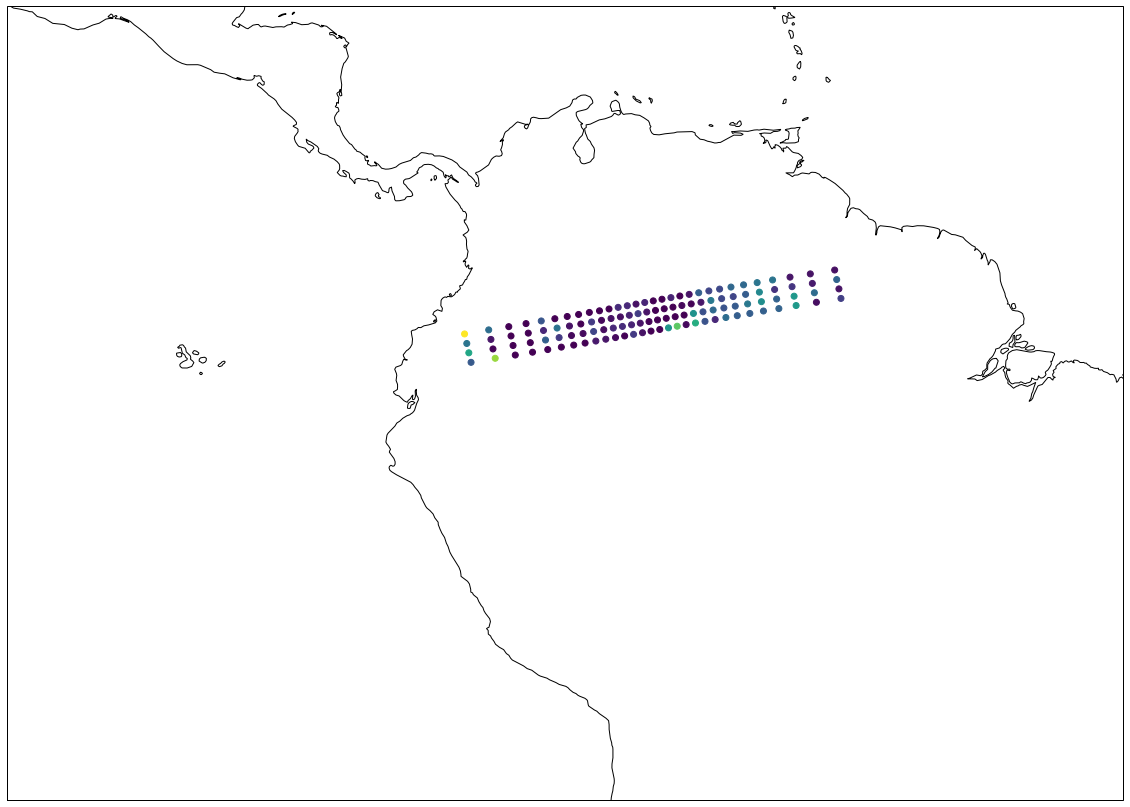

In [9]:
# Makes a crude scatter plot of CAPE. Would be better if turned into a gridded plot
fig = plt.figure(figsize=[20,20])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines('50m')
ax.set_extent([-100, -45,-20, 15])
plt.scatter(lons, lats, c=capes)
plt.show()

In [12]:
# Import CSV file, this has the QC info in the column called 'priority'
ctl_file = pd.read_csv(csv_fname)

# For clarity, I am printing all the column names
ctl_file.columns

Index(['icao', 'iata', 'synop', 'name', 'state', 'country', 'lat', 'lon',
       'elev', 'priority', 'srcid', 'ctf_low', 'ctf_high', 'ctp_low',
       'ctp_high', 'blmult'],
      dtype='object')

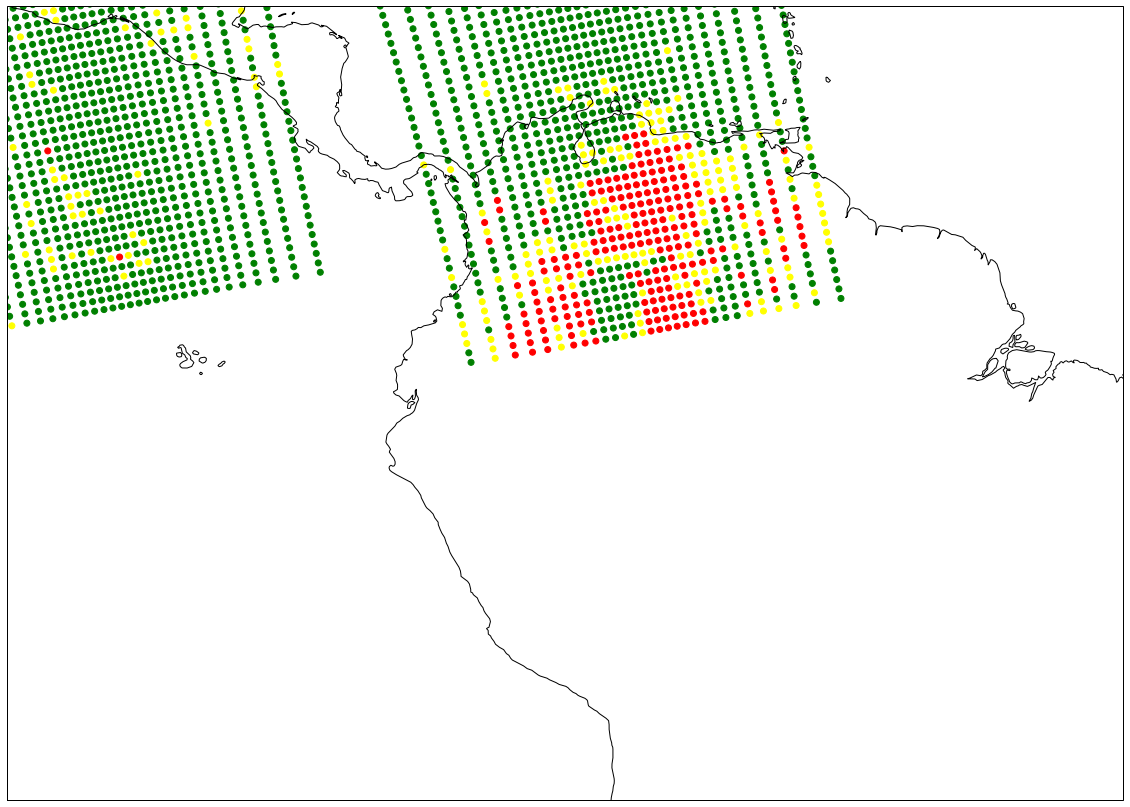

In [13]:
# Making a QC plot...again would be better if gridded...
fig = plt.figure(figsize=[20,20])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines('50m')
ax.set_extent([-100, -45,-20, 15])
plt.scatter(ctl_file.lon, ctl_file.lat, c=ctl_file.priority)
plt.show()